<h3>CNN time series classification, FordA -dataset (car engine condition recognition)</h3>

This example is based on this:<br/>
<a href="https://keras.io/examples/timeseries/timeseries_classification_from_scratch/">https://keras.io/examples/timeseries/timeseries_classification_from_scratch/</a>

<b>Usual imports</b>

In [17]:
import keras
import numpy as np
import matplotlib.pyplot as plt

# if your Jupyter kernel crashes during this code, use this setting
# import os
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

<b>Download the data into our project (FordA)</b>

In [18]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [19]:
print(f"Amount of training data: {len(x_train)} signals")
print(f"Amount of test data: {len(x_test)} signals")

Amount of training data: 3601 signals
Amount of test data: 1320 signals


In [20]:
# inspect one piece of training data
x_train[0]

array([-7.9717168e-01, -6.6439208e-01, -3.7301463e-01,  4.0815121e-02,
        5.2693599e-01,  9.8428794e-01,  1.3531202e+00,  1.5781078e+00,
        1.6592509e+00,  1.6408093e+00,  1.5522896e+00,  1.4379516e+00,
        1.2793537e+00,  1.0691193e+00,  7.4454700e-01,  2.7760541e-01,
       -3.0072351e-01, -9.3732792e-01, -1.5200828e+00, -1.9516165e+00,
       -2.1360326e+00, -2.0401363e+00, -1.7229406e+00, -1.2619003e+00,
       -8.0454833e-01, -4.6153436e-01, -2.7822475e-01, -2.5130000e-01,
       -3.0183001e-01, -3.1326381e-01, -2.0445830e-01,  6.7002208e-02,
        4.7161115e-01,  9.3265143e-01,  1.3531202e+00,  1.6444976e+00,
        1.7588356e+00,  1.6961341e+00,  1.4822114e+00,  1.1797690e+00,
        8.2569008e-01,  4.4948122e-01,  7.2534692e-02, -2.9703519e-01,
       -6.4595047e-01, -9.7421115e-01, -1.2508353e+00, -1.4094332e+00,
       -1.4278748e+00, -1.3024718e+00, -1.0627309e+00, -7.4922349e-01,
       -4.1727450e-01, -1.0745543e-01,  1.6879990e-01,  3.9784471e-01,
      

In [21]:
len(x_train[0])

500

In [22]:
# SUMMARY:
# we have 3601 signals for training
# we have 1320 signal for testing
# all signals are 500 data points

# our total data is:
print((3601 * 500) + (1320 * 500))

2460500


In [23]:
#  +1 indicates that a specific symptom exists, -1 indicates that the symptom does not exist
y_train

array([-1,  1, -1, ..., -1,  1, -1])

In [24]:
len(y_train)

3601

In [25]:
y_train[0]

-1

<b>Let's try visualizing some of the signals</b>

<Figure size 640x480 with 0 Axes>

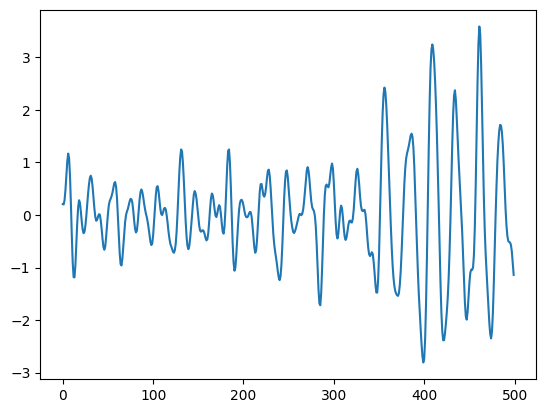

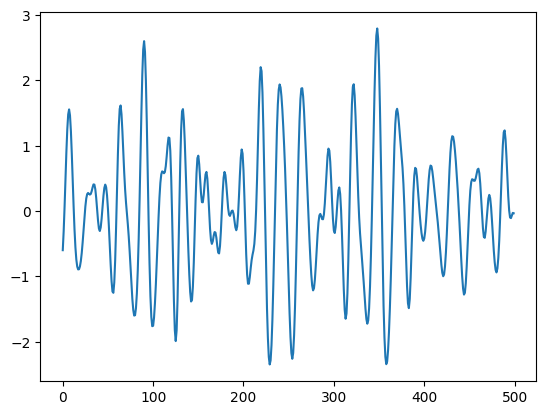

In [43]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

signal_index = 25

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.figure()
    plt.plot(c_x_train[signal_index], label="class " + str(c))
    plt.show()


In [27]:
# convert the data into the required CNN -format
# usuallu the easiest approach is to modify
# your own data to follow the data format used by another example 
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [28]:
x_train

array([[[-0.79717168],
        [-0.66439208],
        [-0.37301463],
        ...,
        [-0.66439208],
        [-1.0737958 ],
        [-1.5643427 ]],

       [[ 0.80485472],
        [ 0.63462859],
        [ 0.37347448],
        ...,
        [-0.71488505],
        [-0.56044294],
        [-0.31908642]],

       [[ 0.7279851 ],
        [ 0.11128392],
        [-0.49912439],
        ...,
        [ 0.39446303],
        [ 0.33940042],
        [ 0.25539062]],

       ...,

       [[-0.57005428],
        [-0.33316523],
        [-0.29351853],
        ...,
        [-1.3937145 ],
        [-0.94273327],
        [-0.27072168]],

       [[ 2.0067321 ],
        [ 2.0791499 ],
        [ 2.0220362 ],
        ...,
        [-0.43214504],
        [-0.44123126],
        [-0.28070891]],

       [[-0.12524091],
        [-0.32536268],
        [-0.48823697],
        ...,
        [ 0.55576053],
        [ 0.57445102],
        [ 0.57311598]]])

In [29]:
# save the number of output classes into a helper variable
num_classes = len(np.unique(y_train))

In [30]:
# CNN networks usually benefit from shuffling the training data
# NOTE: ONLY SHUFFLE TRAINING DATA; DO NOT SHUFFLE TESTING DATA EVER
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]


In [31]:
# out of convenience, change -1 to 0 
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [32]:
def make_model(input_shape):
    # input layer
    input_layer = keras.layers.Input(input_shape)

    # convolutional layer 1
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    # convolutional layer 2
    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    # convolutional layer 3 
    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    # pooling + flatten
    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    # dense -layer or the "tail of the neural network"
    # this allows us to connect back to our output layer
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])

# pip install pydot -> restart Kernel
# keras.utils.plot_model(model, show_shapes=True)

In [33]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.6104 - sparse_categorical_accuracy: 0.6439 - val_loss: 0.8352 - val_sparse_categorical_accuracy: 0.4674 - learning_rate: 0.0010
Epoch 2/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.4572 - sparse_categorical_accuracy: 0.7807 - val_loss: 0.8707 - val_sparse_categorical_accuracy: 0.4674 - learning_rate: 0.0010
Epoch 3/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.4527 - sparse_categorical_accuracy: 0.7712 - val_loss: 0.8099 - val_sparse_categorical_accuracy: 0.4674 - learning_rate: 0.0010
Epoch 4/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.4243 - sparse_categorical_accuracy: 0.7943 - val_loss: 0.7512 - val_sparse_categorical_accuracy: 0.4674 - learning_rate: 0.0010
Epoch 5/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.4282 - sparse_categorical_accuracy: 0.7832 - val_loss: 0.6343 - val_sparse_categorical_accuracy: 0.6616 - learning_rate: 0.0010
Epoch 6/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/ste

<b>Test accuracy/loss</b>

In [34]:
model = keras.models.load_model("best_model.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0871 - sparse_categorical_accuracy: 0.9668
Test accuracy 0.967424213886261
Test loss 0.09528983384370804


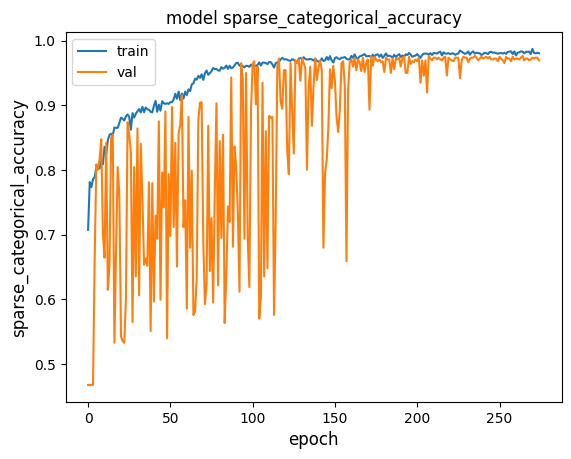

In [35]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

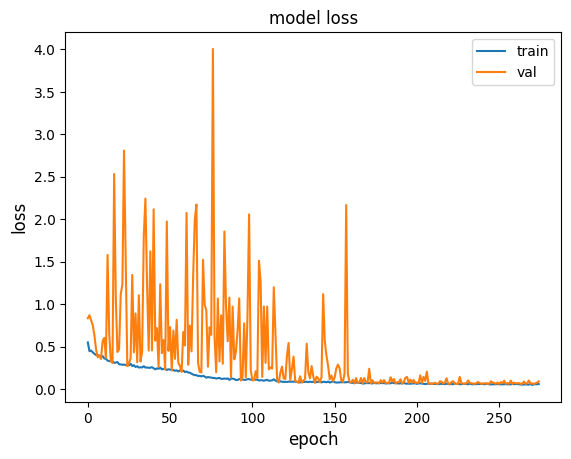

In [36]:
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [37]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


<Axes: >

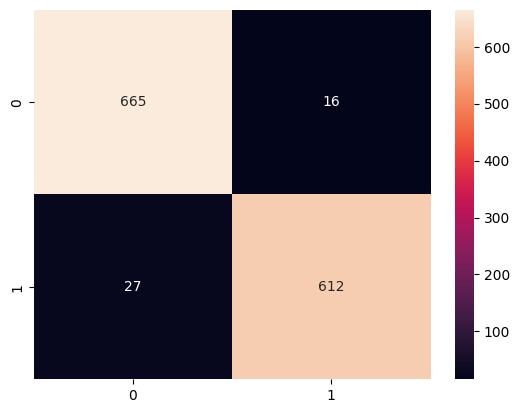

In [38]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

In [39]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       681
           1       0.97      0.96      0.97       639

    accuracy                           0.97      1320
   macro avg       0.97      0.97      0.97      1320
weighted avg       0.97      0.97      0.97      1320


Model overall accuracy: 96.74%


In [40]:
# print the ROC AUC -score
roc_auc_score(y_test, model.predict(x_test)[:, 1])

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


0.9942044172359987

In [41]:
y_test[25]

0

In [42]:
x_test[25]

array([[-0.8073552 ],
       [-0.89655916],
       [-0.91315524],
       [-0.86751601],
       [-0.77831205],
       [-0.66421397],
       [-0.52729628],
       [-0.35926092],
       [-0.16529418],
       [ 0.05999767],
       [ 0.2921354 ],
       [ 0.50166097],
       [ 0.65517475],
       [ 0.73193164],
       [ 0.7236336 ],
       [ 0.63442964],
       [ 0.50166097],
       [ 0.36474327],
       [ 0.24857068],
       [ 0.17637771],
       [ 0.14629731],
       [ 0.1552177 ],
       [ 0.1734734 ],
       [ 0.16227104],
       [ 0.1048071 ],
       [ 0.00359172],
       [-0.12899025],
       [-0.28042952],
       [-0.42149624],
       [-0.53766883],
       [-0.61235121],
       [-0.64554338],
       [-0.64554338],
       [-0.61442572],
       [-0.5521904 ],
       [-0.44846487],
       [-0.32191973],
       [-0.1601079 ],
       [ 0.02929491],
       [ 0.22367655],
       [ 0.39793544],
       [ 0.53485314],
       [ 0.62820611],
       [ 0.67591986],
       [ 0.68006888],
       [ 0

In [45]:
categories = {0: "No symptom", 1: "Symptom present"}

# in this case, the model is 100% sure
# this belongs to class 0 (original -1)
result = model.predict([x_test[25]])[0]

print(result)
print(categories[np.argmax(result)])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[1. 0.]
No symptom
